# 03 - Interactive Viz

### To read the notebook with rendered maps, please go to [this page](https://nbviewer.jupyter.org/github/justcho5/ADA/blob/master/Homework%203/Homework3.ipynb).

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Task 1

#### Strategy:
There are many flavors of unemployment datasets on the eurostat website and we decided to use the annual survey (LFSA) results from the European Union Labour Force Survey (EU-LFS). According to the LFSA metadata, unemployed persons is defined as "persons aged 15-74 who were without work during the reference week, were currently available for work and were either actively seeking work in the past four weeks or had already found a job to start within the next three months."

Our approach is to first clean the data and extract the 2016 unemployment rates for EU and EFTA countries. We then use this data to build a Choropleth map. For our map, we choose the light orange to dark red range of colors because the colors in this range are easy to distinguish from each other. We associate the red with higher unemployment rates because we intuitively associate red with "worse" states.

Then, we wanted to create popups for each country to expand the data. For these popups we display unemployment rates over a decade (from 2006 to 2016) for males, females, and all persons. 

The analysis follows our visualizations.
   

To start with, we load and clean up the annual unemployment rates in 2015 from ```lfsa```.

In [1]:
# Modules that are needed
import json
import numpy as np
import pandas as pd
import folium
import folium.plugins
%matplotlib inline

In [2]:
# Load EU unemployment data
eu_rate_annual = pd.read_csv('Data/lfsa_urgan_1_Data.csv')

eu_rate_annual['Value'] = eu_rate_annual['Value'].replace(to_replace = ':', value = float('NaN'))
eu_rate_annual.Value = eu_rate_annual.Value.astype(float)

# We clean the data to only include the necessary information: Country, Time, and Percentage
eu_rate_annual.loc[eu_rate_annual['GEO'] == 'Germany (until 1990 former territory of the FRG)', 'GEO'] = 'Germany'
eu_rate_annual.loc[eu_rate_annual['GEO'] == 'Former Yugoslav Republic of Macedonia, the', 'GEO'] = "The former Yugoslav Republic of Macedonia"



eu_rate_annual = eu_rate_annual[~(eu_rate_annual['TIME']==2005)]
eu_rate_annual = eu_rate_annual[~(eu_rate_annual['GEO'].isin(('European Union (28 countries)', 
                                'European Union (27 countries)', 
                                'European Union (15 countries)',
                                'Euro area (19 countries)',
                                'Euro area (18 countries)',
                                'Euro area (17 countries)')))]
eu_rate = eu_rate_annual[eu_rate_annual['AGE'] == 'From 15 to 74 years']
eu_rate = eu_rate[eu_rate['SEX']== 'Total']
eu_rate = eu_rate[eu_rate['TIME']== 2016]

eu_rate = eu_rate[['GEO', 'TIME', 'Value']]
eu_rate.columns = ['Country', 'Year', 'Percentage']
eu_rate.Percentage = eu_rate.Percentage.astype(float)

Here, we make the visualizations using vincent. First, we will visualize unemployment rate by gender (Male, Female), and then we will visualize unemployment rate by age groups (15-29, 30-39, 40-49, 50-59, 60-69, 70-74).

In [3]:
import vincent
vincent.core.initialize_notebook()

# For each EU/EFTA country, we plot the unemployment rates by Males and Females 
# between the ages of 15 and 74 years for the years 2006 to 2016.
plots = eu_rate_annual[eu_rate_annual['AGE'] == 'From 15 to 74 years'][['GEO','SEX','TIME', 'Value']]
plots.Value = plots.Value.astype(float)
plots.TIME = plots.TIME.astype(str)

# Separate the data into dataframes for unemployment rates of males and rates of females and merge them side by side
male = plots[plots['SEX']=='Males']
female = plots[plots['SEX']=='Females']
result = pd.merge(male, female, how='left', on = ['GEO','TIME'])
result = result[['GEO', 'TIME','Value_x', 'Value_y']]
result.columns =['Country', 'year', 'Males', 'Females']


# Array of countries
countries = eu_rate['Country'].unique()

# For each country, visualize the unemployment rates as grouped bar plots
for country in countries:
    plots = result[result['Country'] == country]
    plots = plots[['year', 'Males', 'Females']]
    plots = plots.set_index('year')
    bar = vincent.GroupedBar(plots)
    bar.axis_titles(x='Year', y='Unemployment Rate (%)')
    bar.legend(title=country)
    bar.height = 250
    bar.width = 400

    # Output visualization as a json
    bar.to_json('Visualizations/%s_sex.json' %country)

We will visualize unemployment rate by grouping in age groups (15-29, 30-39, 40-49, 50-59, 60-69, 70-74).

In [4]:
# For each EU/EFTA country, we plot the unemployment rates by age group 
# for each population for the years 2006 to 2016.
plots_age = eu_rate_annual[eu_rate_annual['SEX'] == 'Total'][['GEO','AGE','TIME', 'Value']]
plots_age['Value'] = plots_age['Value'].replace(to_replace = ':', value = float('NaN'))
plots_age.Value = plots_age.Value.astype(float)

# Separate the data into dataframes for unemployment rates of age groups
age_range = plots_age['AGE'].unique().tolist()
age_result = plots_age[plots_age['AGE']=='From 15 to 74 years']
age_range.remove('From 15 to 74 years')

# Merge the age group dataframes side by side
for age in age_range:
    age_result = pd.merge(age_result, plots_age[plots_age['AGE'] == age], how = 'left', on = ['GEO','TIME'], suffixes=(age, age) )

# Clean up the resulting to dataframe to have Country, Year, and columns for age groups
age_result.columns=['Country', 'AGE_x', 'Year', 'From 15 to 74 years', 
                    'AGEFrom 15 to 24 years','From 15 to 24 years', 
                    'AGE_x', 'From 25 to 29 years',
                    'AGEFrom 30 to 34 years', 'From 30 to 34 years', 
                    'AGE_x','From 35 to 39 years', 
                    'AGEFrom 40 to 44 years', 'From 40 to 44 years',
                    'AGE_x', 'From 45 to 49 years', 
                    'AGEFrom 50 to 54 years','From 50 to 54 years', 
                    'AGE_x', 'From 55 to 59 years',
                    'AGEFrom 60 to 64 years', 'From 60 to 64 years', 
                    'AGE_x','From 65 to 69 years', 
                    'AGEFrom 70 to 74 years', 'From 70 to 74 years']


age_result = age_result[['Country', 
                         'Year', 
                         'From 15 to 74 years',
                         'From 15 to 24 years','From 25 to 29 years',
                         'From 30 to 34 years','From 35 to 39 years',  
                         'From 40 to 44 years','From 45 to 49 years',
                         'From 50 to 54 years','From 55 to 59 years',
                         'From 60 to 64 years','From 65 to 69 years', 
                         'From 70 to 74 years']]

# For each country, visualize the unemployment rates by age groups as grouped bar plots. We first
# average two consecutive groups to reduce the number of groups we plot.
for country in countries:
    plots_age = age_result[age_result['Country'] == country]
    plots_age = plots_age.set_index('Year')

    plots_age = plots_age[['From 15 to 24 years', 
                           'From 25 to 29 years',
                           'From 30 to 34 years',
                           'From 35 to 39 years',  
                           'From 40 to 44 years',
                           'From 45 to 49 years', 
                           'From 50 to 54 years', 
                           'From 55 to 59 years',
                           'From 60 to 64 years', 
                           'From 65 to 69 years', 
                           'From 70 to 74 years']]
    
    # Take the mean of two consecutive columns of dataframe
    age_grouped = pd.DataFrame()
    for i in range(0, 11, 2):
        if i < 10:
            age_grouped[age_range[i]] = plots_age.iloc[:,[i,i+1]].mean(axis = 1, skipna = True)
        else: 
            age_grouped[age_range[i]] = plots_age.iloc[:,i]
    
    # Rename the columns
    age_grouped.columns = ['From 15 to 29 years',
                           'From 30 to 39 years',
                           'From 40 to 49 years',
                           'From 50 to 59 years',
                           'From 60 to 69 years',
                           'From 70 to 79 years']
    
    # Create the grouped bar plots
    bar = vincent.GroupedBar(age_grouped)
    bar.axis_titles(x='Year', y='Unemployment Rate (%)')
    bar.legend(title=country)
    bar.colors(brew='Set1')
    bar.height = 300
    bar.width = 350
    
    # Output visualization as a json
    bar.to_json('Visualizations/%s_age.json' %country)

Now that we have our visualizations ready, we want to make our map! We first make a choropleth map by creating an overlay that displays our unemployment data as a color spectrum on the map. In addition we add popups to each country to display unemployment rates for males vs. females data over a decade. Then a second map contains unemployment rate based on age groups.

Because folium has more render options for geojson file, we decide to transform topojson file to geojson file. We use [this website](http://jeffpaine.github.io/geojson-topojson/) to do the transformation.

In [5]:
# We create the map
eu_map = folium.Map(location=[57.51833,20.6122144],zoom_start=3)

# load boundaries of countries
geo_json_data = json.load(open('topojson/europe.geojson.json'))

# We apply the europe geojson overlay and bind our unemployment rate data 
# to the geojson objects with a yellow to red color scale
eu_map.choropleth(geo_data = geo_json_data,
                  data = eu_rate,
                  columns = ['Country', 'Percentage'],
                  key_on = 'feature.properties.NAME',
                  highlight = True,
                  fill_color = 'OrRd',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = 'Unemployment rate in the EU (%)',
                  name = '2016 unemployment rate'
                 )

We add popups to each country to display the unemployment rate over 2006 to 2016 for males and for females.

In [6]:
# Here we create popups for each country and within the popups we load our bar plots that we created above.
for feature in geo_json_data['features']:
    name = feature['properties']['NAME']
    if name in countries:
        x = folium.GeoJson(feature['geometry'],
                           name = feature['properties']['NAME']+'_gender',
                           style_function = lambda x:{'fillOpacity': '0.0', 'color': 'black', 'weight': 1},
                           highlight_function = lambda y: {'fillOpacity': '0.2'}
                          ).add_child(folium.Popup(max_width=600).add_child(
            folium.Vega(json.load(open('Visualizations/%s_sex.json' %name)), width=500, height=300))).add_to(eu_map)

folium.LayerControl().add_to(eu_map)
eu_map.save(outfile= 'eu_map.html')

We do the same to visualize our age group figures on a map

In [7]:
# Here we a map to display our popups for each country. 
eu_map_age = folium.Map(location=[57.51833,20.6122144],zoom_start=3)

eu_map_age.choropleth(geo_data = geo_json_data,
                  data = eu_rate,
                  columns = ['Country', 'Percentage'],
                  key_on = 'feature.properties.NAME',
                  highlight = True,
                  fill_color = 'OrRd',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = 'Unemployment rate in the EU (%)',
                  name = '2016 unemployment rate'
                 )
# We create popups for each country and within the popups we load our bar plots that we created above.
for feature in geo_json_data['features']:
    name = feature['properties']['NAME']
    if name in countries:
        x = folium.GeoJson(feature['geometry'],
                           name = feature['properties']['NAME']+'_agegroup',
                           style_function = lambda x:{'fillOpacity': '0.0', 'color': 'black', 'weight': 1},
                           highlight_function = lambda y: {'fillOpacity': '0.2'}
                          ).add_child(folium.Popup(max_width=600).add_child(
            folium.Vega(json.load(open('Visualizations/%s_age.json' %name)), width=500, height=350))).add_to(eu_map_age)

folium.LayerControl().add_to(eu_map_age)
eu_map_age.save(outfile= 'eu_map_age.html')

### MAP 1: Unemployment rate -> By Gender

In this map, we first visualize the unemployment rate for 2016 in EU and EFTA countries. The intensity of the color corresponds to the unemployment rate. For example, countries with 20 percent and greater unemployment will be colored a darker red, and those with unemployment rates below 6 percent will be a light orange. 

Furthermore, we make the map interactive by allowing the user to click the countries to reveal a popup that displays unemployment rates of males and females in that country over the period of 2006 to 2016.

In [8]:
# display the map using html
from IPython.core.display import HTML
url = 'EU_unemployment_rate.html'
eu_map.save(url)
HTML('<iframe src=' + url + ' width=100% height=500></iframe>')

#### Observations:

We can clearly see the differences in unemployment rate when visualized in this choropleth. It's apparent that Greece and the former Yugoslav Republic of Macedonia have the highest unemployment rates in 2016, both above 20%. We can click on these countries to observe unemployment trends over the years and based on gender. In Greece, the unemployment rate began to rise after 2008 and hit a peak around 2013 and has been slowly decreasing. From the popup, we see that the unemployment rate of females is higher than of males. In 2006, the average unemployment rate was relatively low between 5 and 13%. For the former Yugoslave Rep. of Macedonia, the unemployment rate in the past decade has always been relatively high between 23 to 35%. It has consistently been decreasing from ~35% to ~23%. Furthermore, the unemployment rate of females is lower than of males.

In Switzerland, the unemployment rate has always been relatively low, from 3.5 to 5%. Although low, we can see that the unemployment rate of females was higher than males a decade ago, but now they are relatively the same.

### MAP 2: Unemployment rate --> By age group
While analyzing the unemployment data, we were also provided with unemployment rates within age groups. We create another map to present this data. Like above, we create popups for each country which display the unemployment rate in age groups from 2006 to 2016.

In [9]:
# display the map using html
from IPython.core.display import HTML
url = 'EU_unemployment_rate_age.html'
eu_map_age.save(url)
HTML('<iframe src=' + url + ' width=100% height=500></iframe>')

#### Observations
The figure in the popups shows the unemployment rate over 2006 to 2016 by age group per country. Overall, we see that the 15-29 years old age group has the highest unemployment rate over all the age groups. As a general observation, this makes sense because many people in this group are just starting their career. The older age groups have much lower unemployment rates. Thus, we can imagine that the choropleth visualizing unemployment in 2016 might have a higher weight on the 15-29 year old group because they bias the average unemployment rate for the total popuplation. In many countries, there is little to no information on the unemployment rate for the age group 70-79 years and this may be due to the fact that many people retire before this age.

Like the rest of Europe, Switzerland has the highest unemployment rate in the 15 to 29 years age group.


In addition to this information, we wanted to compare switzerland in particular to the rest of Europe. We get the rank of switzerland compared to the rest of europe and the unemployment rate of Switzerland over 2006 to 2016.

In [10]:
# We can collect the rank of Switzerland among Europe for unemployment rate and also look at the
# unemployment rate of Switzerland over 2006 to 2016.
years= {}
rate = {}
for year in range(2006, 2017, 1):
    a = eu_rate_annual[eu_rate_annual['TIME']==year]
    x = a[a['AGE'] == 'From 15 to 74 years']
    total = x[x['SEX']=='Total'][['GEO', 'TIME', 'Value']].sort_values('Value')
    total['Rank'] = pd.Series(list(range(1,34,1)), index = total.index)
    years[year] = total.loc[total['GEO']=='Switzerland']['Rank'].values
    rate[year] = total.loc[total['GEO'] == 'Switzerland']['Value'].values
    
    

In [11]:
# We convert the data into arrays that can be plotted in a graph
x = []
y = []

x_rate = []
y_rate = []
for year in years:
    x.append(year)
    y.append(years[year][0])

for year in rate:
    x_rate.append(year)
    y_rate.append(rate[year][0])

<function matplotlib.pyplot.show>

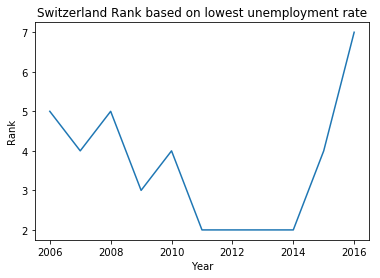

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y)
plt.ylabel('Rank')
plt.xlabel('Year')
plt.title('Switzerland Rank based on lowest unemployment rate')
plt.show

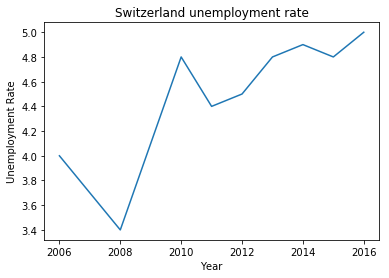

In [13]:
plt.plot(x_rate, y_rate)
plt.ylabel('Unemployment Rate')
plt.xlabel('Year')
plt.title('Switzerland unemployment rate')
plt.show()

#### Observations:

Switzerland consistently has one of the lowest unemployment rates in Europe (EU/EFTA) over the past decade. It ranks in the top 25 percentile for lowest unemployment rate and at one point from 2011 to 2014, it ranked at number 2 for the lowest unemployment rate in Europe. Interestingly, the unemployment rate in Switzerland, although low, has gradually been increasing over the last decade, ranging from 3.4 to 5%.

## Task 2
In this task, we were asked to build choropleths to show the unemployment rate in every swiss cantons. We tried to put additional information in popups to make the map informative and interactive. The other objective of this task is to experiments with the subtle difference in the definition of unemployment rate. We tried a few definitions and discussed how they differ or resemble each other on the choropleth.

### The first map: the official definition of unemployment rate

#### Collect data from [amstat](https://www.amstat.ch):
We went to [amstat](https://www.amstat.ch) website and found many useful statistics in the ```detail``` page under ```unempolyed tag```. The data we used  were downloaded from ```2.1 Unemployment rate``` because the title directly met the goal of this section.

#### Decide which number to put on the choropleth:
The dataset provides details on the structure of unemployed population. Even though we only need the unemployment rate for this section, we downloaded all of them because it could be useful for the following sections.

#### Build the first choropleth:
We used the ```choropleth``` function to combine boundaries of cantons and the unemployment rates. For the boundary, we decided to transform topojson file to geojson file because folium has more render options for that. We used [this website](http://jeffpaine.github.io/geojson-topojson/) to do the transformation.

In [14]:
# load data
df = pd.read_excel('Data/2_1 Taux de chômage.xlsx', header=8, skip_footer=1)
# use a hand crafted dictionary to get canton ids
dict_name_id = json.load(open('Data/canton_names_ids.json', 'rb'))
df['Canton_id'] = list(map(dict_name_id.get, df.Canton))
# select columns and translate to English
total_rates = df[['Canton', 'Canton_id', 'Taux de chômage',
                  'Chômeurs inscrits', 'Chômeurs de longue durée', 'Demandeurs d\'emploi']]
total_rates.columns = ['Canton', 'Canton_id', 'Unemployment rate',
                       'Registered unemployed', 'Long-term unemployed', 'Jobseekers']
total_rates.head()

Canton Canton_id  Unemployment rate  Registered unemployed  \
0   Neuchâtel        NE                5.8                  64382   
1      Genève        GE                5.5                 155582   
2        Vaud        VD                4.7                 224894   
3        Jura        JU                4.6                  20341   
4  Bâle-Ville        BS                3.9                  45986   

   Long-term unemployed  Jobseekers  
0                 14432       86039  
1                 29765      199113  
2                 41344      314851  
3                  4730       28975  
4                  8014       66020

In [15]:
# define a function to build choropleth
def plot_rate (map, threshold_func=None, name=''):
    if threshold_func:
        threshold = threshold_func(total_rates['Unemployment rate'])
    else:
        threshold = None
    map.choropleth(geo_data = geo_json_data,
                  data = total_rates,
                  columns = ['Canton_id', 'Unemployment rate'],
                  key_on = 'feature.id',
                  threshold_scale = threshold,
                  highlight = True,
                  fill_color = 'BuPu',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = 'Unemployment rate in the Switzerland (%)'+name,
                  name = 'Registered unemployed people'+name)

In [16]:
# load boundaries of cantons
geo_json_data = json.load(open('topojson/ch-cantons.geojson.json', 'rb'))
# create map
ch_location = [46.9, 8.3]
ch_map = folium.Map(location=ch_location, tiles='cartodbpositron', zoom_start=8)
plot_rate(ch_map)
ch_map

#### Observation

We can see that the unemployment rate is higher in western Switzerland than in other regions. Zurich is definitely an exception of this trend. Nevertheless, this still leads to a higher average unemployment rate in French speaking zone compare to the other ones. Note that we can not draw any conclusion on the relation between the population and the unemployment rate from this map: Zurich, the largest city in Switzerland, is not in the top positions; and Neuchatel, one of the least populated cantons, ranks number 1.

### The second map: a different way to look at unemployment rate
In this section, we studied how different types of jobseekers, i.e. employed and non-employed, in the statistics affect the unemployment rate. We compared the results of using these two statistics in the choropleth.

#### Derive the statistics
We had enough information in the dataset, but we didn't have a directly number so we decided to derive different unemployment rate from the given ones. According the the official definition, the unemployment rate considers registered unemployed people, which is exactly the non-employed jobseeker, so we only had to compute the new unemployment rate considering all jobseekers, including the employed ones. We did this using the following formula.

$$\text{New unemployment rate}=\frac{\text{# All jobseekers}}{\text{Active population}}
=\frac{\text{# All jobseekers}}{\frac{\text{# Registered unemployed}}{\text{Official unemployment rate}}}
$$

#### Build the choropleth & add a layer controler to the map
To make the comparison between two choropleth easier, we put them in one map and added a controler so that viewers can choose which one to show.

In [17]:
# compute the new unemployment rate
def to_rate2 (s):
    return s['Jobseekers'] / (s['Registered unemployed'] / s['Unemployment rate'])

rate2 = [to_rate2(row) for _, row in total_rates.iterrows()]
rate2 = pd.Series(rate2, index=total_rates.Canton_id)
rate2.head()

Canton_id
NE    7.751020
GE    7.038870
VD    6.579987
JU    6.552529
BS    5.599052
dtype: float64

In [18]:
# define another function to build choropleth with different parameters
def plot_rate2 (map, threshold_func=None, name=''):
    if threshold_func:
        threshold = threshold_func(rate2)
    else:
        threshold = None
    map.choropleth(geo_data = geo_json_data,
              data = rate2,
              key_on = 'feature.id',
              highlight = True,
              threshold_scale = threshold,
              fill_color = 'YlOrRd',
              fill_opacity = 0.7,
              line_opacity = 0.2,
              legend_name = 'Unemployment rate (w/ all jobseekers) in the Switzerland (%)'+name,
              name = 'Registered unemployed + employed jobseekers'+name)

In [19]:
plot_rate2(ch_map)
folium.LayerControl().add_to(ch_map)
ch_map

#### Observation
First of all, as a direct result from the definition, this new unemployment rate gives higher value than the previous one. However, the two choropleths are very similar: they both have the same trend that unemployment rate is higher in the west and Zurich stands out from the German speaking area. In fact, these two unemployment rates are highly correlated even without geographical information. From the scatter plot below, we can see that the points almost stay on one line and the correlation coefficient is 0.98.

Correlation =  0.967401119113


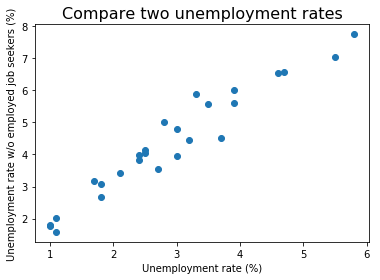

In [20]:
# analysis without geographical information
x, y = total_rates['Unemployment rate'], rate2
print('Correlation = ', np.corrcoef([x,y])[0,1])
# scatter plot
fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xlabel('Unemployment rate (%)')
ax.set_ylabel('Unemployment rate w/o employed job seekers (%)')
_=ax.set_title('Compare two unemployment rates', fontsize=16)

### Data classification: quantile classification, standard deviation classification
The default classification of choropleth in folium is equal interval classification. In what follows, we tried another 2 classifications, i.e. quantile classification and standard deviation classification, and discussed how they affected the results. Because folium doesn't provide options to users, we defined our own functions to generate these 2 classifications.

In [21]:
# create standard deviation classification thresholds
def std_dev_class (s):
    vals = np.sort(s.values)
    v_min, v_max = np.min(vals), np.max(vals)
    v_mean, v_std = np.mean(vals), np.std(vals)
    threshold = [v_mean-v_std*2, v_mean-v_std, v_mean,
                 v_mean+v_std, v_mean+v_std*2, v_mean+v_std*3]
    return threshold

In [22]:
# create quantile classification thresholds
def quantile_class (s, n=5):
    vals = np.sort(s.values)
    idx = np.linspace(0, len(vals)-1, n+1).astype(int)
    threshold = list(vals[idx])
    threshold[0], threshold[-1] = \
        (1.01*threshold[0]-0.01*threshold[-1],
         1.01*threshold[-1]-0.01*threshold[0])
    return threshold

In [23]:
# compare 2 classifications within one map
m = folium.Map(location=ch_location, tiles='cartodbpositron', zoom_start=8)
plot_rate(m, quantile_class, ', quantile classification')
plot_rate(m, std_dev_class, ', standard deviation classification')
folium.LayerControl().add_to(m)
m

#### Observation
For quantile classification, which tends to have the same number of data in each group, the colors gave us an impression that there are several cantons having equally high or equally low unemployment rates. This is not the case for standard deviation classification. Similar to equal interval classification, it splits out extreme data at both ends so we could easily read this from the map. Also, we could directly learn some statistical information from the map using standard deviation classification, e.g. almost all French speaking cantons have unemployment rates 1 standard deviation higher than the average.

---

# Task 3

The Amstat site has a [tool](https://www.amstat.ch/MicroStrategy/servlet/mstrWeb?src=mstrWeb.2001&evt=2001&hiddensections=header%2Cpath%2CdockLeft%2Cerror%2CdockRight%2CdockBottom%2Cfooter&folderID=BC73E533438ED32A0D56628D8206644A&) that allows users to download the data they collected in various formats, including CSV.
One of the stats they provide is the unemployment rate in Switzerland by canton and nationality (Swiss or foreign). The statistics are only provided in Italian, French and German so after downloading the data we also need to translate everything to English. For this part we chose Italian because it's the native language of one of the members of the group. We created some JSON dictionaries to map the names of the columns to English and the names of the cantons to those that are used in the provided topojson files.

In [24]:
# Dictionary for mapping Italian canton names to the names used in the topojson file
canton_dict = json.load(open('Data/canton_names_it.json', encoding='utf-8'))
# Dictionary for mapping Italian column names to English
column_dict = json.load(open('Data/column_names_it.json', encoding='utf-8'))

In [25]:
# Load the data, need to specify encoding and skip some rows and columns
ch_unemployment_by_nationality = pd.read_csv('Data/ch_unemployment_rate_by_nationality_2016.csv',
                   skiprows=[1],
                   encoding='utf-16',
                   usecols=[0, 1, 15],
                   skipfooter=1,
                   engine='python'
    )

In [26]:
# Translate nationality from Italian
ch_unemployment_by_nationality['Nazionalità'].replace('stranieri', 'Foreign', inplace=True)
ch_unemployment_by_nationality['Nazionalità'].replace('svizzeri', 'Swiss', inplace=True)

# Translate Canton names so that they match the geojson file
ch_unemployment_by_nationality['Cantone'].replace(canton_dict, inplace=True)

# Translate column names to English
ch_unemployment_by_nationality.rename(columns=column_dict, inplace=True)

ch_unemployment_by_nationality.head()

Canton Nationality  Average
0      Zürich     Foreign      6.0
1      Zürich       Swiss      2.8
2  Bern/Berne     Foreign      6.5
3  Bern/Berne       Swiss      2.0
4      Luzern     Foreign      4.7

We can now draw a choropleth map to show the unemployment rate for each canton by nationality. Instead of drawing two separate maps we chose to draw two separate overlays and make their visibility toggleable using checkboxes. Since folium ignores some of the options (for example highlighting) when using topojson for map data we decided to convert the provided file to geojson.

In [27]:
# Set the initial coordinates for the map
ch_coord = [46.849, 8.394]

# Load GeoJSON data for Swiss cantons
canton_geo_path = 'topojson/ch-cantons.geojson.json'
canton_geo_data=json.load(open(canton_geo_path, encoding='utf-8'))

# Draw the map
ch_map = folium.Map(location=ch_coord, zoom_start=8)

# Draw overlay for unemployment of foreign workers
ch_map.choropleth(
    canton_geo_data,
    data=ch_unemployment_by_nationality[ch_unemployment_by_nationality.Nationality == 'Foreign'],
    key_on='feature.properties.name',
    fill_color = 'BuPu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    columns=('Canton', 'Average'),
    name='Foreign',
    highlight=True,
    legend_name='Unemployment rate of foreign workers'
)

# Draw overlay for unemployment of Swiss workers
ch_map.choropleth(
    canton_geo_data,
    data=ch_unemployment_by_nationality[ch_unemployment_by_nationality.Nationality == 'Swiss'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    columns=('Canton', 'Average'),
    name='Swiss',
    highlight=True,
    legend_name='Unemployment rate of Swiss workers'
)

folium.LayerControl().add_to(ch_map)
ch_map

We can see that unemployment rates for foreign workers are generally higher than those for Swiss workers, and that both are higher in the French speaking part of Switzerland, especially in Neuchâtel and Jura. The difference is less marked in some cantons, like Genève, Vaud, Zurich, Ticino and Basel-Stadt and more in others, like Valais. The differences don't seem to correlate with the [population density](https://commons.wikimedia.org/wiki/File:Bev%C3%B6lkerungsdichte_der_Schweiz_2016.png) or [proportion of foreigners](https://commons.wikimedia.org/wiki/File:Ausl%C3%A4nderanteil_der_Schweiz_2016.png) and there doesn't seem to be a single reason why this happen. In larger and more international cities like Zurich and Geneva this could be happening because foreign workers are likely to be highly skilled and thus have a lower chance of being unemployed but this doesn't explain why other cities like Bern don't have this difference.

#### Part 2

For this next part we're going to need the unemployment rates by canton, nationality and age group. Unfortunately the Amstat's online tool doesn't allow us to select more than one categorization when downloading the unemployment rate file: we can specify either nationality or age group but not both. Therefore we decided to download another file which contains the number of unemployed people by canton, age and nationality and use that to compute the age distributions of foreign and swiss unemployed people in each canton. We could have made some assumptions instead (for example that the age distributions of the two nationalities are the same) but that could have lead to inaccurate results.
Again, the raw data is in Italian and so all names need to be translated.

In [28]:
# Load the data
ch_age_empl_totals = pd.read_csv(
    'Data/ch_unemployment_age_nationality_2016.csv',
    skiprows=[1],
    encoding='utf-16',
    usecols=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
    thousands="'",
    skipfooter=1,
    engine='python'
)

In [29]:
# Make Canton names match the topojson file
ch_age_empl_totals['Cantone'].replace(canton_dict, inplace=True)

# Translate nationality from Italian
ch_age_empl_totals['Nazionalità'].replace('stranieri', 'Foreign', inplace=True)
ch_age_empl_totals['Nazionalità'].replace('svizzeri', 'Swiss', inplace=True)

# Translate column names to English
ch_age_empl_totals.rename(columns=column_dict, inplace=True)

# Add average column, this time it's not in the data
ch_age_empl_totals['Average'] = ch_age_empl_totals.mean(axis=1, numeric_only=True)

# Translate from Italian
ch_age_empl_totals['Age group'].replace('Totale', 'Total', inplace=True)

# Rows where "Nationality" is "Total" have the sum of unemployed people of all nationalities
# We don't need that since we're trying to keep Swiss and foreign workers separate
ch_age_empl_totals = ch_age_empl_totals[ch_age_empl_totals['Nationality'] != 'Totale']
# We also drop any columns we don't need
ch_age_empl_totals = ch_age_empl_totals[['Canton', 'Nationality', 'Age group', 'Average']]

# Reshape the table so that (Canton, Nationality) is our index
# and the different age groups are our columns
ch_age_empl_totals = ch_age_empl_totals.pivot_table(index=['Canton', 'Nationality'],
                                                    values='Average', columns='Age group')

# Compute what fraction of the total unemployed workers belong to each
# age group. This could have been done with GroupBy but it would have been
# much more complicated.
ch_age_empl_totals['1'] = ch_age_empl_totals['1'] / ch_age_empl_totals.Total
ch_age_empl_totals['2'] = ch_age_empl_totals['2'] / ch_age_empl_totals.Total
ch_age_empl_totals['3'] = ch_age_empl_totals['3'] / ch_age_empl_totals.Total

# Drop the total since we no longer need it
unemployed_age_distributions = ch_age_empl_totals.drop('Total', axis=1)

unemployed_age_distributions.head()

Age group                                  1         2         3
Canton                 Nationality                              
Aargau                 Foreign      0.110488  0.687091  0.202421
                       Swiss        0.153528  0.515336  0.331136
Appenzell Ausserrhoden Foreign      0.094639  0.626320  0.279041
                       Swiss        0.158318  0.440217  0.401465
Appenzell Innerrhoden  Foreign      0.127778  0.553704  0.318519

Now that we have a dataframe containing the age distributions of each group we can just multiply them by the unemployment rate of that group from the previous point to get the data we need. The result is not the unemployment rate of that group but rather how large is the subset of unemployed workers that belong to that group relatively to the entire group. This is what we want in order to plot this data in a stacked bar chart because in this way the total height of each bar will keep being equal to the unemployment rate of workers of each nationality in each canton.

In [30]:
# Now reindex the dataframe containing unemployment rates of foreign and Swiss workers
# so that it uses the same index as the one containing the age distributions
unemployment_rates_reindex = ch_unemployment_by_nationality[['Canton', 'Nationality', 'Average']]\
    .set_index(['Canton', 'Nationality'])
    
# Then join the two
unemployment_by_age_nationality = unemployed_age_distributions.join(unemployment_rates_reindex)

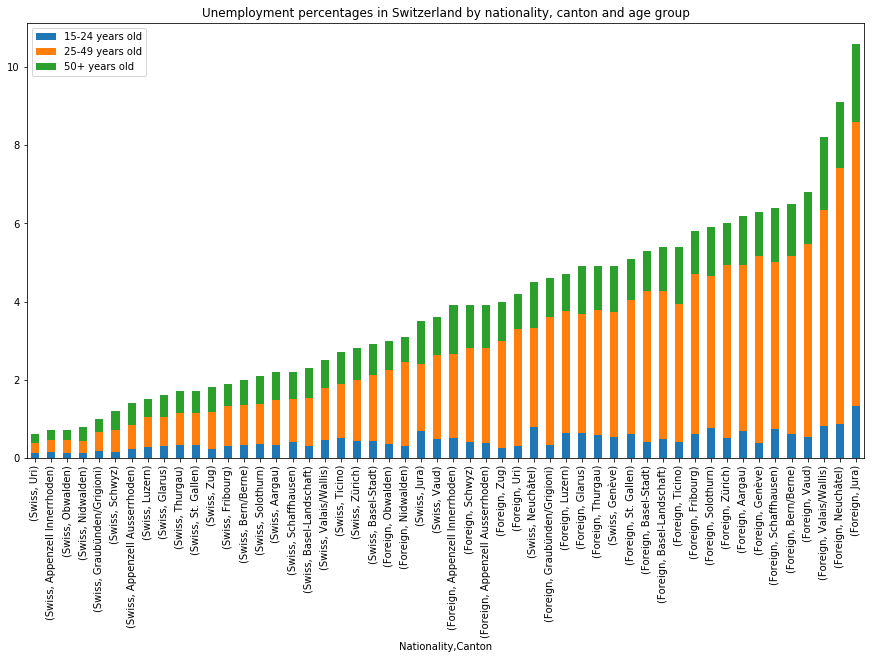

In [31]:
# Multiply the unemployment rate for foreigners and Swiss by the age distributions
# to get the unemployment rate by age and nationality
# Also rename the age groups to something more meaningful
# (1 = 15-24 years old, 2 = 25-49, 3 = 50+)
unemployment_by_age_nationality['15-24 years old'] = \
    unemployment_by_age_nationality['1'] * unemployment_by_age_nationality.Average
unemployment_by_age_nationality['25-49 years old'] = \
    unemployment_by_age_nationality['2'] * unemployment_by_age_nationality.Average
unemployment_by_age_nationality['50+ years old'] = \
    unemployment_by_age_nationality['3'] * unemployment_by_age_nationality.Average

# Plot the result
unemployment_by_age_nationality.sort_values('Average')\
    .drop(['Average', '1', '2', '3'], axis=1)\
    .swaplevel()\
    .plot(
        kind='bar',
        stacked=True,
        figsize=(15, 8),
        title='Unemployment percentages in Switzerland by nationality, canton and age group',
    )

From this plot, we can see that not only the unemployment rate of Swiss workers is always lower than that of foreign workers in the same canton but also that other than a few outliers (Genève, Neuchâtel) the bar chart is split in two with Swiss workers on one side and foreign workers on the other side. The small rural cantons in the German-speaking part of the country (Uri, Appenzell, Obwalden/Nidwalden...) are the ones where unemployment is lowest for both swiss and foreign workers. In all cases most of the unemployed workers fall in the 25-49 age bracket, with the 50+ group being the second most represented.